In [1]:
import sys
sys.path.append('../utils')
from nd_tools import (scale_img,
                      get_superpixel_means_as_features, 
                      get_superpixel_stds_as_features,
                      get_array_from_features)

from rio_tools import polygonize_array_to_shapefile
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb

The goals of this notebook are to:
    
1. Introduce superpixel segmentation as a tool for feature extraction
2. How to use superpixels with SAR imagery and classification

# Innspecting Data

In [2]:
data_dir = Path('../data')
rgb_tif = data_dir/'rgb.tif'
coh_tifs = sorted(list(data_dir.glob('./*coh*.tif')))
coh_tifs

[PosixPath('../data/alos_coh_hh.tif'), PosixPath('../data/alos_coh_hv.tif')]

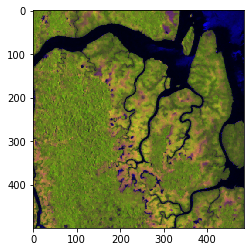

In [3]:
with rasterio.open(rgb_tif) as ds:
    rgb = ds.read().transpose([1, 2, 0])
    profile = ds.profile
plt.imshow(rgb)

# Superpixel Segmentation

Superpixels were first introduced in this [article](https://ttic.uchicago.edu/~xren/publication/xren_iccv03_discrim.pdf) by Ren and Malik. However, there have been numerous subsequent algorithms including the [Felzenszwalb algorithm](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf) which is nicely demonstrated in skimage [here](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html).

For clarity, skimage takes a multichannel image (in this case our RGB composite) and for each segment outputs a unique integer label.

In [4]:
# Check the documentation and papers above for an explanation of parameters
# We don't use sigma because TV is already denoised
superpixel_labels = felzenszwalb(rgb, scale=.5, sigma=0, min_size=15, multichannel=True)

We now visualize the array with each segment as a random color.

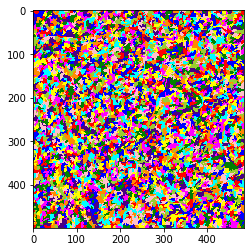

In [5]:
superpixel_labels_viz = label2rgb(superpixel_labels)
plt.imshow(superpixel_labels_viz)

# Viewing Segments in QGIS

To view in QGIS, we use the [`features`](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) module from QGIS and [`fiona`](https://github.com/Toblerity/Fiona) to write these vectors to file. We have written this [answer](https://gis.stackexchange.com/a/187883) from GIS stackexchange into a function.

In [6]:
polygonize_array_to_shapefile(superpixel_labels, profile, 'superpixels')

# Extracting Features from Segments

Within a segment we can extract means, variance, medians, etc. We use the [measurement](https://docs.scipy.org/doc/scipy-0.16.0/reference/ndimage.html#module-scipy.ndimage.measurements) module from scipy's ndimage. We have some functions to make their use slightly more transparent.

In [7]:
std_features = get_superpixel_stds_as_features(superpixel_labels, rgb)
mean_features = get_superpixel_means_as_features(superpixel_labels, rgb)

/Users/cmarshak/anaconda3/envs/sari_test/lib/python3.7/site-packages/scipy/ndimage/measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts


In [8]:
mean_features.shape, len(np.unique(superpixel_labels))

((4772, 3), 4772)

So we create a vector of ($p$ unique labels) $\times$ ($q$ channels). Here $q=3$ as we have an rgb image with three channels.

# Mean Populated Superpixels

We want to create an array corresponding to our map, where every pixel of a particular label is populated with the mean. This is accomplished using `get_array_from_features`, which again is a wrapper for [`labeled_comprehension`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.labeled_comprehension.html#scipy.ndimage.measurements.labeled_comprehension) from scipy.

In [9]:
mean_arr = get_array_from_features(superpixel_labels, mean_features)

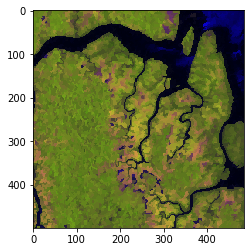

In [10]:
plt.imshow(mean_arr)

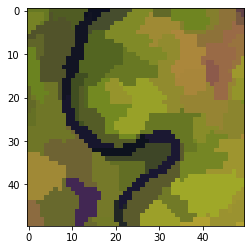

In [11]:
plt.imshow(mean_arr[200:250, 200:250])

## Standard Deviation Populated Superpixels

Using standard deviation features, we can get a proxy for texture or how quickly the pixel values vary in a segment.

In [12]:
std_arr = get_array_from_features(superpixel_labels, std_features)
# because the variance is lower, without scaling the image can't be viewed in imshow.
std_arr = scale_img(std_arr)

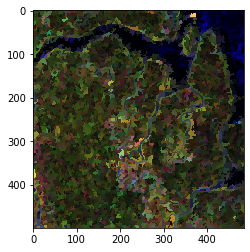

In [13]:
plt.imshow(std_arr)

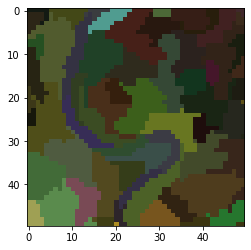

In [14]:
plt.imshow(std_arr[200:250, 200:250])

# K-means with Superpixels

Superpixels can improve model performance by grouping homogeneous areas. We now show how to apply sklearn models to the superpixel features. We use the mean features.

In [15]:
## Answer

model = KMeans(n_clusters=3, 
               random_state=0)
X_train = mean_features.copy()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

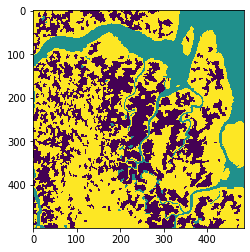

In [16]:
## Answer

class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

# Exercise 1

Use the superpixels found above to aggregate HH coherence using the mean.

In [17]:
## Answer

with rasterio.open(coh_tifs[0]) as ds:
    coh_hh = ds.read(1)

In [18]:
## Answer
coh_mean_features = get_superpixel_means_as_features(superpixel_labels, coh_hh)

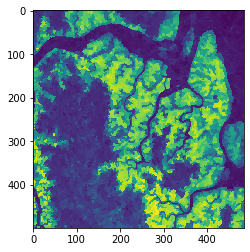

In [19]:
## Answer
coh_mean_arr = get_array_from_features(superpixel_labels, coh_mean_features)
plt.imshow(coh_mean_arr)

# Exercise 2

Use the superpixels mean coherence to classify the image with k-means. What do you notice?

In [20]:
## Answer

model = KMeans(n_clusters=3, 
               random_state=0)
X_train = coh_mean_features.copy()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

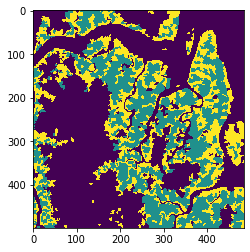

In [21]:
## Answer

class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

That's a pretty good classification, but what two classes are being conflated? Ideas for separating them?


# Exercise 3

Combine coherence and backscatter means from the superpixels to obtain a classification.

In [22]:
## Answer

model = KMeans(n_clusters=4, 
               random_state=0)
X_train = np.concatenate([mean_features, coh_mean_features], axis=1)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

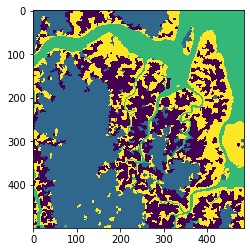

In [23]:
## Answer

class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

In [24]:
## Answer

with rasterio.open(coh_tifs[0]) as ds:
    profile = ds.profile

profile['dtype'] = 'int32'
profile['nodata'] = None
with rasterio.open('classes.tif', 'w', **profile) as ds:
    ds.write(classes.astype(np.int32), 1)

# Acknowledgements

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.
